In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import random

from hmmlearn import hmm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

np.random.seed(42)

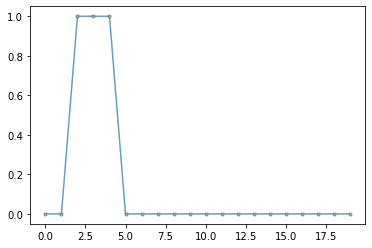

In [2]:
# generate dataset
time_duration = 20     # The length of time sequence
observation_states = 2 #number of observation states
include_noise = 0
sample_length = 200    # how many samples do we want
num_anomaly = 40       # The number of anomaly samples we want


"""This part is to generate a simple dataset, 
where normal behavial is we have a continuous wavelet with a certain length,
while in anomaly cases the wavelet is not continuous"""
y_label = [1] * num_anomaly + [0] * (sample_length - num_anomaly)
#anomaly_label = random.sample(y_label,num_anomaly)
wavelet_length = 3
wavelet = list(map(lambda x: 1, [i for i in range(0,wavelet_length)]))
#wavelet = list(map(lambda x: int(sin(x/10)), [i for i in range(0,wavelet_length)]))
x_dataset = np.zeros((sample_length, 20),dtype='int32')
for i in range(0, num_anomaly):
    insert_num = random.randint(0,int(time_duration/wavelet_length))
    insert_pos = random.sample(range(0,time_duration - wavelet_length),insert_num)
    insert_len = np.random.randint(0, wavelet_length, size = insert_num)
    sample = [0]*time_duration
    for j in range(0, len(insert_pos)):
        sample[insert_pos[j]:insert_pos[j] + insert_len[j]] = wavelet[0: insert_len[j]]
    x_dataset[i] = sample
for i in range(num_anomaly, sample_length):
    insert_pos = random.randint(0,time_duration - wavelet_length)
    sample = [0]*time_duration
    sample[insert_pos: insert_pos + wavelet_length] = wavelet
    x_dataset[i] = sample

plt.plot(x_dataset[65], ".-", label="observations", ms=6, mfc="orange", alpha=0.7)
plt.show()

dataset = {'x': x_dataset, 'y': y_label}

In [3]:
n_anomaly = 40
lengthX = len(dataset['x'])
lengthY = len(dataset['y'])
outlierX = dataset['x'][:n_anomaly]
outlierY = dataset['y'][:n_anomaly] # all ones
nomialX = dataset['x'][n_anomaly:lengthX]
nomialY = dataset['y'][n_anomaly:lengthY]
X_train, X_test, y_train, y_test = train_test_split(
    nomialX, nomialY, test_size = 0.3)
X_test_anomaly = np.concatenate((outlierX, X_test), axis = 0)
y_test_anomaly = np.concatenate((outlierY, y_test), axis = 0)

# concatenate the data into sequences used for fit and predict
X_train_arr = X_train[0]
X_test_anomaly_arr = X_test_anomaly[0]
X_test_arr = X_test[0]
X_train_len = [len(X_train[0])]
X_test_len = [len(X_test[0])]
X_test_anomaly_len = [len(X_test[0])]

for i in range(X_train.shape[0] - 1):
    X_train_arr = np.concatenate([X_train_arr, X_train[i + 1]])
    X_train_len = np.concatenate([X_train_len, [len(X_train[i + 1])]])

for i in range(X_test_anomaly.shape[0] - 1):
    X_test_anomaly_arr = np.concatenate([X_test_anomaly_arr, X_test_anomaly[i + 1]])
    X_test_anomaly_len = np.concatenate([X_test_anomaly_len, [len(X_test_anomaly[i + 1])]])

for i in range(X_test.shape[0] - 1):
    X_test_arr = np.concatenate([X_test_arr, X_test[i + 1]])
    X_test_len = np.concatenate([X_test_len, [len(X_test[i + 1])]])




In [5]:
my_file = open("./dataset/Test_anomaly_set_array.txt", "w")
for element in X_test_anomaly_arr:
    my_file.write(str(int(element)) + '\n')
my_file.close()
# Test_anomaly_set_array.txt is the file stores the data array

my_file = open("./dataset/Test_anomaly_set_array_size.txt", "w")
my_file.write(str(len(X_test_anomaly_arr)))
my_file.close()
# Test_anomaly_set_array_size.txt is the file stores the size of data array

my_file = open("./dataset/Test_anomaly_set_length.txt", "w")
for element in X_test_anomaly_len:
    my_file.write(str(int(element)) + '\n')
my_file.close()
# Test_anomaly_set_length.txt is the file stores the length array (length of each samples)

my_file = open("./dataset/Test_anomaly_set_samples.txt", "w")
my_file.write(str(len(X_test_anomaly_len)))
my_file.close()
# Test_anomaly_set_samples.txt is the file stores the number of samples

my_file = open("./dataset/Test_anomaly_set_label.txt", "w")
for element in y_test_anomaly:
    my_file.write(str(int(element)) + '\n')
my_file.close()
# Test_anomaly_set_label.txt is the file stores the labels of samples

In [6]:
n_components = 5
n_features = 2
model = hmm.MultinomialHMM(n_components = n_components)

# initialize number of features V
model.n_features = n_features

le = preprocessing.LabelEncoder()
le.fit([0., 1.])

# train the model
data = X_train_arr
data = le.transform(data)
model.fit(data.reshape(-1, 1), X_train_len)

MultinomialHMM(n_components=5,
               random_state=RandomState(MT19937) at 0x7F92A135E340)

<function matplotlib.pyplot.show(close=None, block=None)>

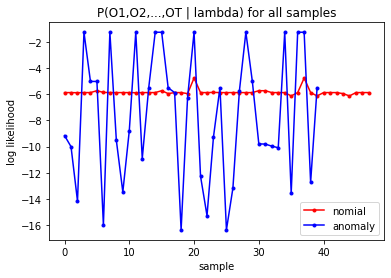

In [65]:
# Plot the log likelihood for each sample sequence

data = X_test[0]
data = le.transform(data)
score_nomial = [model.score(data.reshape(-1, 1))]
for i in range(len(X_test) - 1):
    data = X_test[i + 1]
    data = le.transform(data)
    score_nomial = np.concatenate([score_nomial, [model.score(data.reshape(-1, 1))]])
plt.plot(score_nomial[:], ".-", label="nomial", color = 'r')

data = X_test_anomaly[0]
data = le.transform(data)
score_anomaly = [model.score(data.reshape(-1, 1))]
for i in range(n_anomaly - 1):
    data = X_test_anomaly[i + 1]
    data = le.transform(data)
    score_anomaly = np.concatenate([score_anomaly, [model.score(data.reshape(-1, 1))]])
plt.plot(score_anomaly[:], ".-", label="anomaly", color = 'b')   

plt.xlabel("sample")
plt.ylabel("log likelihood")
plt.title("P(O1,O2,...,OT | lambda) for all samples")
plt.legend()

plt.show

In [7]:
# do anomaly detection and obtain precision, recall and F-score
TP = 0
TN = 0
FP = 0
FN = 0
for i in range(len(X_test_anomaly)):
    data = X_test_anomaly[i]
    data = le.transform(data)
    if(model.score(data.reshape(-1, 1)) < -10.):
        positive = 1
    else:
        positive = 0
    if(positive):
        if(y_test_anomaly[i] == 1):
            TP += 1
        else:
            FP += 1
    else:
        if(y_test_anomaly[i] == 0):
            TN += 1
        else:
            FN += 1
print("TP =", TP, "TN =", TN, "FP =", FP, "FN =", FN )
Precision = "{:.0%}".format(TP / (TP + FP))
Recall = "{:.0%}".format(TP / (TP + FN))
Fscore = "{:.0%}".format(2 * TP / (2 * TP + FP + FN))
print("Precision =", Precision, "Recall =", Recall, "Fscore =", Fscore)

TP = 13 TN = 48 FP = 0 FN = 27
Precision = 100% Recall = 32% Fscore = 49%


In [26]:
# save the model to file
import pickle
with open("HMMModel.pkl", "wb") as file: pickle.dump(model, file)

In [27]:
# load the model from file
import pickle
with open("HMMModel.pkl", "rb") as file: pickle.load(file)

In [28]:
# store the model parameters
my_file = open("./Model_Parameters/N_Features.txt", "w")
my_file.write(str(model.n_features))
my_file.close()

my_file = open("./Model_Parameters/N_Components.txt", "w")
my_file.write(str(model.n_components))
my_file.close()

my_file = open("./Model_Parameters/Initial_Probability_Matrix.txt", "w")
np.savetxt(my_file, model.startprob_)
my_file.close()

my_file = open("./Model_Parameters/Transition_Probability_Matrix.txt", "w")
for row in model.transmat_:
    np.savetxt(my_file, row)
my_file.close()

my_file = open("./Model_Parameters/Emission_Probability_Matrix.txt", "w")
for row in model.emissionprob_:
    np.savetxt(my_file, row)
my_file.close()

In [66]:
score_complete = np.concatenate((score_anomaly, score_nomial), axis = 0)
my_file = open("./Result/LogP.txt", "w")
np.savetxt(my_file, score_complete)
my_file.close()